# Cosmetic Sales Segmentation Analysis
This notebook performs customer and product segmentation analysis on cosmetic sales data using clustering techniques.

## 1. Import Libraries

In [1]:
# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA

# Machine Learning - Clustering
from sklearn.cluster import KMeans, DBSCAN
import hdbscan
import umap

# Metrics
from sklearn.metrics import silhouette_score, davies_bouldin_score

# Settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

print("✅ All libraries imported successfully!")
print(f"UMAP version: {umap.__version__}")
print(f"HDBSCAN version: {hdbscan.__version__}")

c:\Users\HP\Desktop\VScode\Cosmetic_Sales_Segementation\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ All libraries imported successfully!
UMAP version: 0.5.11


AttributeError: module 'hdbscan' has no attribute '__version__'

## 2. Load and Explore Data

In [2]:
# Load the dataset
df = pd.read_csv('cosmetics_sales_data.csv')

print("Dataset Shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset Shape: (374, 6)

First few rows:


,Sales Person,Country,Product,Date,Amount ($),Boxes Shipped
0,Lucas Verma,Canada,Aloe Vera Gel,2022-04-30,7897.13,358
1,Ethan Reddy,UK,Aloe Vera Gel,2022-01-25,16376.88,449
2,Ananya Gupta,India,Body Butter Cream,2022-08-22,5599.68,264
3,Ananya Gupta,New Zealand,Salicylic Acid Cleanser,2022-08-26,2966.47,144
4,Sophia Nair,UK,Body Butter Cream,2022-05-19,6828.68,484


In [3]:
# Data info
print("Dataset Information:")
df.info()

print("\n" + "="*50)
print("Missing Values:")
print(df.isnull().sum())

print("\n" + "="*50)
print("Statistical Summary:")
df.describe()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 374 entries, 0 to 373
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Sales Person   374 non-null    object 
 1   Country        374 non-null    object 
 2   Product        374 non-null    object 
 3   Date           374 non-null    object 
 4   Amount ($)     374 non-null    float64
 5   Boxes Shipped  374 non-null    int64  
dtypes: float64(1), int64(1), object(4)
memory usage: 17.7+ KB

Missing Values:
Sales Person     0
Country          0
Product          0
Date             0
Amount ($)       0
Boxes Shipped    0
dtype: int64

Statistical Summary:


,Amount ($),Boxes Shipped
count,374.000000,374.000000
mean,7778.353262,249.072193
std,5655.378093,144.235296
min,119.820000,10.000000
25%,3325.250000,140.000000
50%,6513.655000,246.000000
75%,11331.897500,364.000000
max,23977.480000,499.000000


## 3. Data Preprocessing

In [4]:
# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract date features
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Quarter'] = df['Date'].dt.quarter
df['DayOfWeek'] = df['Date'].dt.dayofweek

print("✅ Date features extracted")
df.head()

✅ Date features extracted


,Sales Person,Country,Product,Date,Amount ($),Boxes Shipped,Year,Month,Quarter,DayOfWeek
0,Lucas Verma,Canada,Aloe Vera Gel,2022-04-30,7897.13,358,2022,4,2,5
1,Ethan Reddy,UK,Aloe Vera Gel,2022-01-25,16376.88,449,2022,1,1,1
2,Ananya Gupta,India,Body Butter Cream,2022-08-22,5599.68,264,2022,8,3,0
3,Ananya Gupta,New Zealand,Salicylic Acid Cleanser,2022-08-26,2966.47,144,2022,8,3,4
4,Sophia Nair,UK,Body Butter Cream,2022-05-19,6828.68,484,2022,5,2,3


In [5]:
# Check unique values in categorical columns
categorical_cols = ['Sales Person', 'Country', 'Product']

for col in categorical_cols:
    print(f"\n{col}: {df[col].nunique()} unique values")
    print(df[col].value_counts().head())


Sales Person: 10 unique values
Sales Person
Olivia D'Souza    47
Ananya Gupta      42
Noah Mehta        40
Sophia Nair       40
Isabella Roy      38
Name: count, dtype: int64

Country: 6 unique values
Country
USA            75
New Zealand    73
Australia      70
UK             61
India          48
Name: count, dtype: int64

Product: 15 unique values
Product
Hydrating Face Serum    31
Hair Repair Oil         30
Tea Tree Moisturizer    30
Anti-Aging Serum        29
Vitamin C Cream         28
Name: count, dtype: int64


## 4. Exploratory Data Analysis

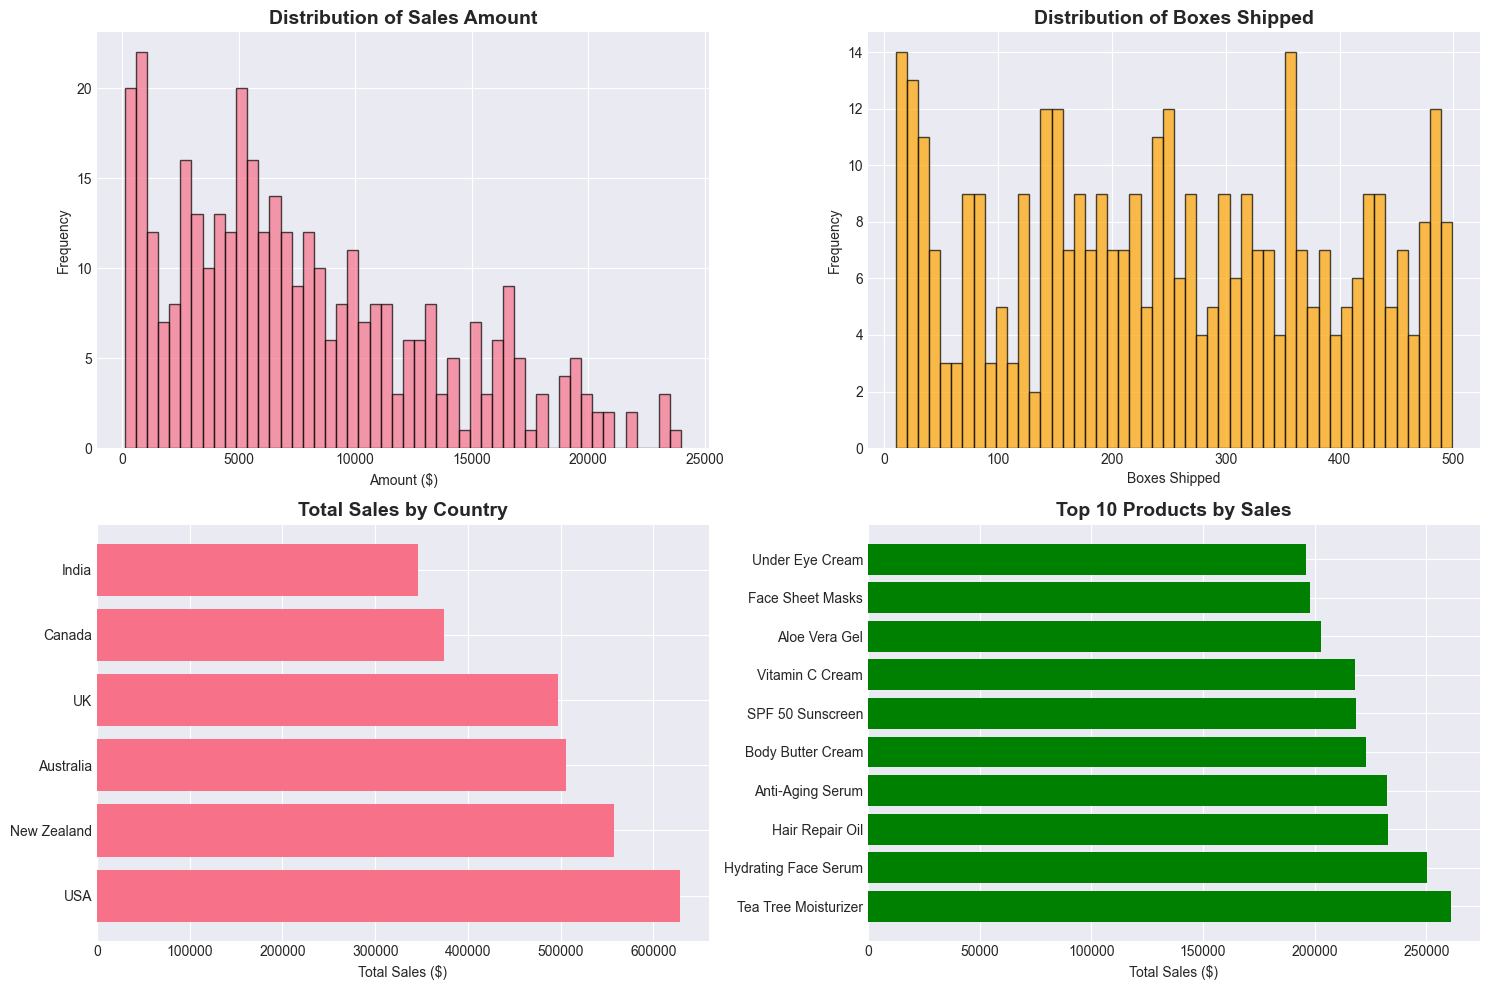

In [6]:
# Sales distribution
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Amount distribution
axes[0, 0].hist(df['Amount ($)'], bins=50, edgecolor='black', alpha=0.7)
axes[0, 0].set_title('Distribution of Sales Amount', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Amount ($)')
axes[0, 0].set_ylabel('Frequency')

# Boxes shipped distribution
axes[0, 1].hist(df['Boxes Shipped'], bins=50, edgecolor='black', alpha=0.7, color='orange')
axes[0, 1].set_title('Distribution of Boxes Shipped', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Boxes Shipped')
axes[0, 1].set_ylabel('Frequency')

# Sales by Country
country_sales = df.groupby('Country')['Amount ($)'].sum().sort_values(ascending=False)
axes[1, 0].barh(country_sales.index, country_sales.values)
axes[1, 0].set_title('Total Sales by Country', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Total Sales ($)')

# Top products
product_sales = df.groupby('Product')['Amount ($)'].sum().sort_values(ascending=False).head(10)
axes[1, 1].barh(product_sales.index, product_sales.values, color='green')
axes[1, 1].set_title('Top 10 Products by Sales', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Total Sales ($)')

plt.tight_layout()
plt.show()

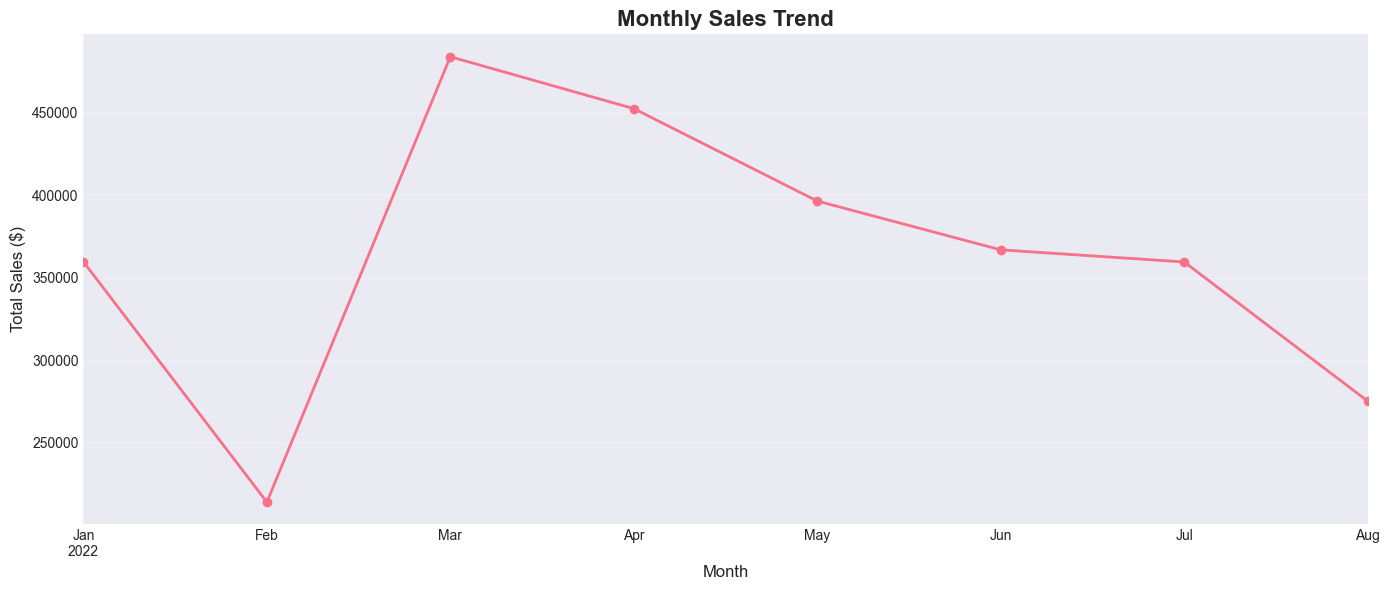

In [7]:
# Sales trends over time
monthly_sales = df.groupby(df['Date'].dt.to_period('M'))['Amount ($)'].sum()

plt.figure(figsize=(14, 6))
monthly_sales.plot(kind='line', marker='o', linewidth=2)
plt.title('Monthly Sales Trend', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales ($)', fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Feature Engineering for Clustering

In [ ]:
# Create aggregated features for customer segmentation
customer_features = df.groupby('Sales Person').agg({
    'Amount ($)': ['sum', 'mean', 'std', 'count'],
    'Boxes Shipped': ['sum', 'mean'],
    'Country': lambda x: x.nunique(),
    'Product': lambda x: x.nunique()
}).reset_index()

# Flatten column names
customer_features.columns = ['_'.join(col).strip('_') for col in customer_features.columns.values]
customer_features.rename(columns={'Sales Person': 'Sales_Person'}, inplace=True)

# Fill NaN in std with 0 (for salespeople with only 1 transaction)
customer_features.fillna(0, inplace=True)

print("Customer Features Shape:", customer_features.shape)
customer_features.head()

Customer Features Shape: (10, 9)


,Sales_Person,Amount ($)_sum,Amount ($)_mean,Amount ($)_std,Amount ($)_count,Boxes Shipped_sum,Boxes Shipped_mean,Country_<lambda>,Product_<lambda>
0,Ananya Gupta,293204.67,6981.063571,4634.908898,42,9669,230.214286,6,14
1,Ava Sharma,246174.28,8791.938571,4892.020511,28,7849,280.321429,6,13
2,Ethan Reddy,298595.61,8531.303143,6625.950668,35,8814,251.828571,6,13
3,Isabella Roy,302087.60,7949.673684,5989.713414,38,9116,239.894737,6,15
4,Liam Patel,270960.55,7526.681944,5557.530548,36,8513,236.472222,6,14


In [ ]:
# Create aggregated features for product segmentation
product_features = df.groupby('Product').agg({
    'Amount ($)': ['sum', 'mean', 'std', 'count'],
    'Boxes Shipped': ['sum', 'mean'],
    'Country': lambda x: x.nunique(),
    'Sales Person': lambda x: x.nunique()
}).reset_index()

# Flatten column names
product_features.columns = ['_'.join(col).strip('_') for col in product_features.columns.values]
product_features.rename(columns={'Product': 'Product_Name'}, inplace=True)

# Fill NaN
product_features.fillna(0, inplace=True)

print("Product Features Shape:", product_features.shape)
product_features.head()

Product Features Shape: (15, 9)


,Product_Name,Amount ($)_sum,Amount ($)_mean,Amount ($)_std,Amount ($)_count,Boxes Shipped_sum,Boxes Shipped_mean,Country_<lambda>,Sales Person_<lambda>
0,Aloe Vera Gel,202901.75,8116.070000,5207.063183,25,6941,277.640000,6,10
1,Anti-Aging Serum,232248.00,8008.551724,5772.896946,29,7423,255.965517,6,9
2,Body Butter Cream,222923.58,9288.482500,5916.886774,24,7065,294.375000,6,10
3,Charcoal Face Wash,102733.42,4892.067619,3565.776990,21,3562,169.619048,6,9
4,Face Sheet Masks,197882.89,8603.603913,6543.621387,23,5893,256.217391,6,8


## 6. Customer Segmentation with K-Means

In [ ]:
# Prepare data for clustering
X_customer = customer_features.drop('Sales_Person', axis=1)

# Standardize features
scaler_customer = StandardScaler()
X_customer_scaled = scaler_customer.fit_transform(X_customer)

print("Scaled Customer Features Shape:", X_customer_scaled.shape)

Scaled Customer Features Shape: (10, 8)


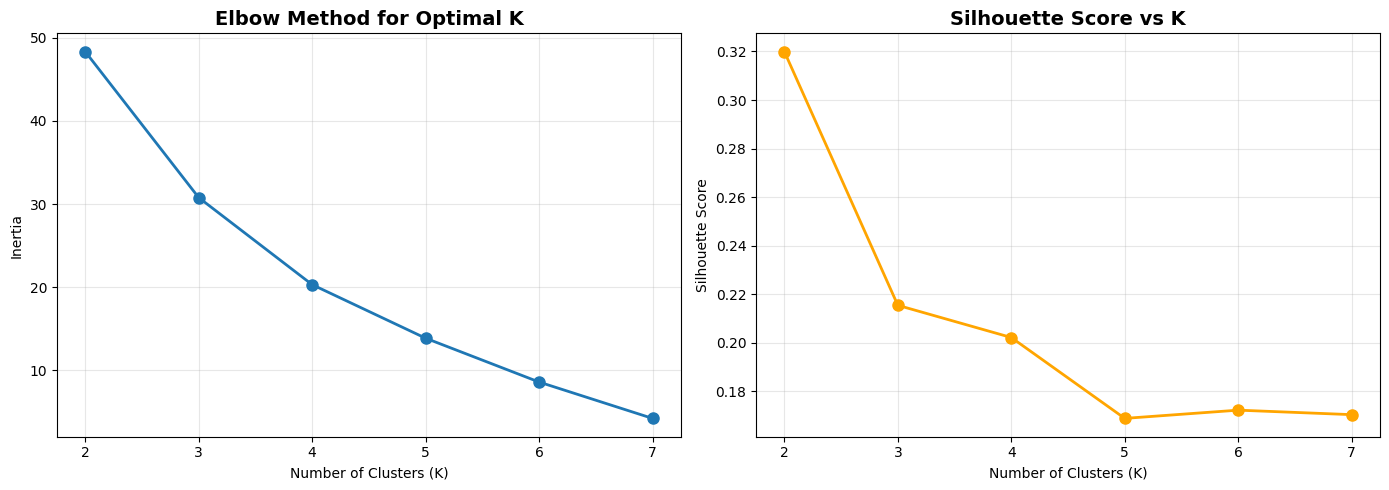


Silhouette Scores:
K=2: 0.3199
K=3: 0.2155
K=4: 0.2022
K=5: 0.1689
K=6: 0.1723
K=7: 0.1705


In [ ]:
# Elbow method to find optimal K
inertias = []
silhouette_scores = []
K_range = range(2, 8)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_customer_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_customer_scaled, kmeans.labels_))

# Plot results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(K_range, inertias, marker='o', linewidth=2, markersize=8)
axes[0].set_title('Elbow Method for Optimal K', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Clusters (K)')
axes[0].set_ylabel('Inertia')
axes[0].grid(True, alpha=0.3)

axes[1].plot(K_range, silhouette_scores, marker='o', linewidth=2, markersize=8, color='orange')
axes[1].set_title('Silhouette Score vs K', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Number of Clusters (K)')
axes[1].set_ylabel('Silhouette Score')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nSilhouette Scores:")
for k, score in zip(K_range, silhouette_scores):
    print(f"K={k}: {score:.4f}")

In [ ]:
# Apply K-Means with optimal K (let's use 3)
optimal_k = 3
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
customer_features['Cluster_KMeans'] = kmeans.fit_predict(X_customer_scaled)

print(f"✅ K-Means clustering completed with K={optimal_k}")
print("\nCluster Distribution:")
print(customer_features['Cluster_KMeans'].value_counts().sort_index())

✅ K-Means clustering completed with K=3

Cluster Distribution:
Cluster_KMeans
0    1
1    4
2    5
Name: count, dtype: int64


## 7. Customer Segmentation with HDBSCAN

In [ ]:
# Apply HDBSCAN
hdbscan_clusterer = hdbscan.HDBSCAN(min_cluster_size=2, min_samples=1, metric='euclidean')
customer_features['Cluster_HDBSCAN'] = hdbscan_clusterer.fit_predict(X_customer_scaled)

print("✅ HDBSCAN clustering completed")
print("\nCluster Distribution (HDBSCAN):")
print(customer_features['Cluster_HDBSCAN'].value_counts().sort_index())
print(f"\nNumber of noise points (cluster -1): {(customer_features['Cluster_HDBSCAN'] == -1).sum()}")

✅ HDBSCAN clustering completed

Cluster Distribution (HDBSCAN):
Cluster_HDBSCAN
-1    4
 0    4
 1    2
Name: count, dtype: int64

Number of noise points (cluster -1): 4


## 8. Dimensionality Reduction with UMAP

In [ ]:
# Apply UMAP for 2D visualization
umap_reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=5, min_dist=0.1)
X_customer_umap = umap_reducer.fit_transform(X_customer_scaled)

customer_features['UMAP_1'] = X_customer_umap[:, 0]
customer_features['UMAP_2'] = X_customer_umap[:, 1]

print("✅ UMAP dimensionality reduction completed")

NameError: name 'umap' is not defined

KeyError: 'UMAP_1'

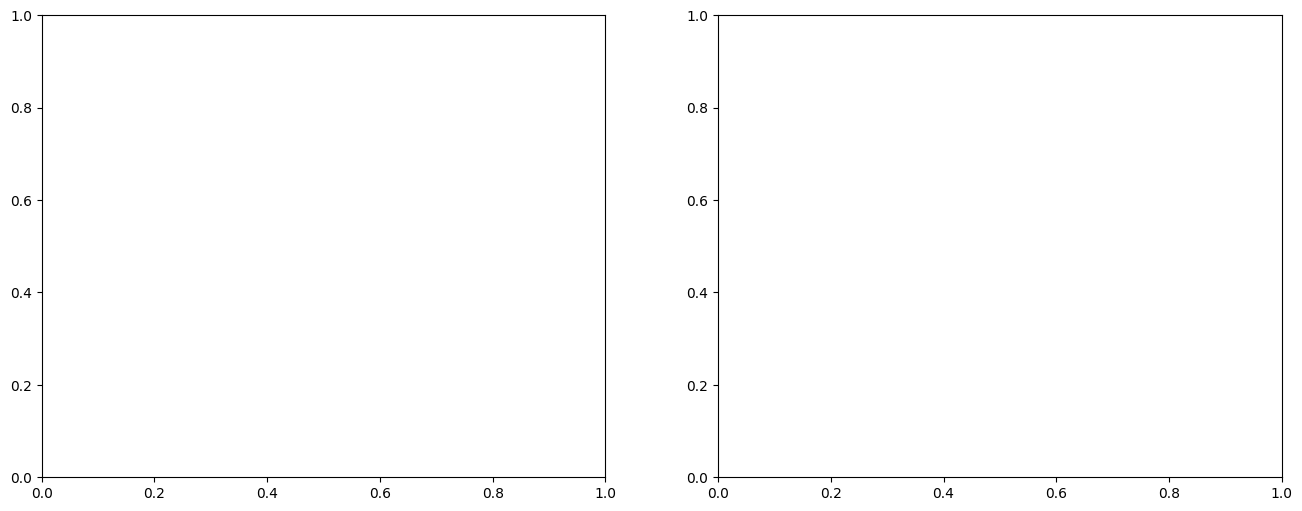

In [ ]:
# Visualize clusters using UMAP
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# K-Means clusters
scatter1 = axes[0].scatter(customer_features['UMAP_1'], 
                           customer_features['UMAP_2'],
                           c=customer_features['Cluster_KMeans'],
                           cmap='viridis',
                           s=100,
                           alpha=0.7,
                           edgecolors='black')
axes[0].set_title('Customer Segments (K-Means) - UMAP Projection', fontsize=14, fontweight='bold')
axes[0].set_xlabel('UMAP Dimension 1')
axes[0].set_ylabel('UMAP Dimension 2')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# HDBSCAN clusters
scatter2 = axes[1].scatter(customer_features['UMAP_1'], 
                           customer_features['UMAP_2'],
                           c=customer_features['Cluster_HDBSCAN'],
                           cmap='plasma',
                           s=100,
                           alpha=0.7,
                           edgecolors='black')
axes[1].set_title('Customer Segments (HDBSCAN) - UMAP Projection', fontsize=14, fontweight='bold')
axes[1].set_xlabel('UMAP Dimension 1')
axes[1].set_ylabel('UMAP Dimension 2')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

## 9. PCA Visualization (Alternative)

In [ ]:
# Apply PCA for comparison
pca = PCA(n_components=2)
X_customer_pca = pca.fit_transform(X_customer_scaled)

customer_features['PCA_1'] = X_customer_pca[:, 0]
customer_features['PCA_2'] = X_customer_pca[:, 1]

print(f"✅ PCA completed")
print(f"Explained variance ratio: {pca.explained_variance_ratio_}")
print(f"Total variance explained: {pca.explained_variance_ratio_.sum():.2%}")

✅ PCA completed
Explained variance ratio: [0.49086514 0.30473124]
Total variance explained: 79.56%


KeyError: 'UMAP_1'

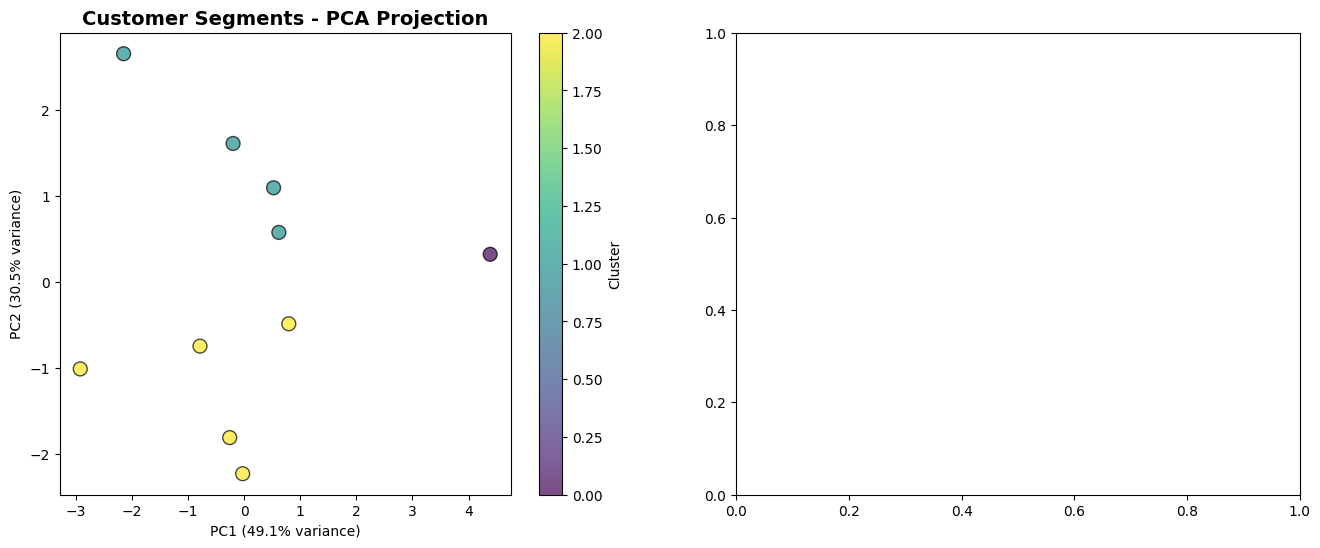

In [ ]:
# Compare PCA vs UMAP visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA visualization
scatter1 = axes[0].scatter(customer_features['PCA_1'], 
                           customer_features['PCA_2'],
                           c=customer_features['Cluster_KMeans'],
                           cmap='viridis',
                           s=100,
                           alpha=0.7,
                           edgecolors='black')
axes[0].set_title('Customer Segments - PCA Projection', fontsize=14, fontweight='bold')
axes[0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
plt.colorbar(scatter1, ax=axes[0], label='Cluster')

# UMAP visualization
scatter2 = axes[1].scatter(customer_features['UMAP_1'], 
                           customer_features['UMAP_2'],
                           c=customer_features['Cluster_KMeans'],
                           cmap='viridis',
                           s=100,
                           alpha=0.7,
                           edgecolors='black')
axes[1].set_title('Customer Segments - UMAP Projection', fontsize=14, fontweight='bold')
axes[1].set_xlabel('UMAP Dimension 1')
axes[1].set_ylabel('UMAP Dimension 2')
plt.colorbar(scatter2, ax=axes[1], label='Cluster')

plt.tight_layout()
plt.show()

## 10. Cluster Analysis and Interpretation

In [ ]:
# Analyze cluster characteristics
cluster_summary = customer_features.groupby('Cluster_KMeans').agg({
    'Amount ($)_sum': 'mean',
    'Amount ($)_mean': 'mean',
    'Amount ($)_count': 'mean',
    'Boxes Shipped_sum': 'mean',
    'Country_<lambda>': 'mean',
    'Product_<lambda>': 'mean',
    'Sales_Person': 'count'
}).round(2)

cluster_summary.columns = ['Avg Total Sales', 'Avg Transaction Value', 'Avg Num Transactions', 
                           'Avg Boxes Shipped', 'Avg Countries Served', 'Avg Products Sold', 'Num Salespeople']

print("Cluster Characteristics (K-Means):")
print("="*100)
cluster_summary

Cluster Characteristics (K-Means):


,Avg Total Sales,Avg Transaction Value,Avg Num Transactions,Avg Boxes Shipped,Avg Countries Served,Avg Products Sold,Num Salespeople
Cluster_KMeans,,,,,,,
0,387405.91,8242.68,47.00,12619.0,6.0,15.00,1
1,289956.16,8379.88,34.75,9116.5,6.0,13.25,4
2,272374.72,7248.88,37.60,8813.6,6.0,14.00,5


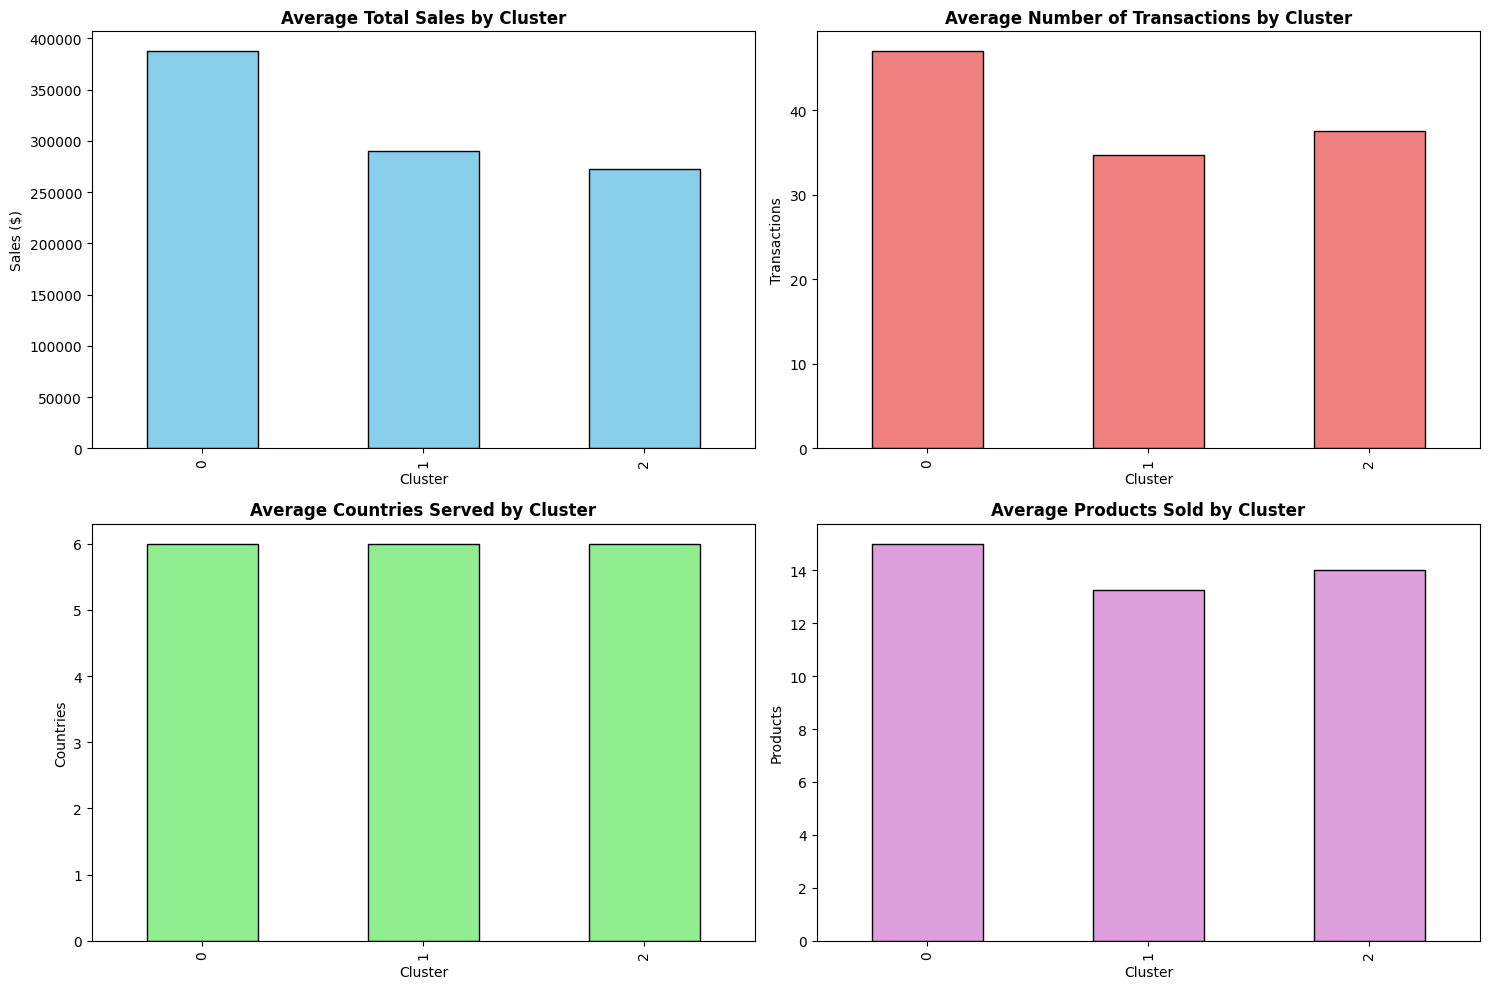

In [ ]:
# Visualize cluster characteristics
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

cluster_summary['Avg Total Sales'].plot(kind='bar', ax=axes[0, 0], color='skyblue', edgecolor='black')
axes[0, 0].set_title('Average Total Sales by Cluster', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Sales ($)')
axes[0, 0].set_xlabel('Cluster')

cluster_summary['Avg Num Transactions'].plot(kind='bar', ax=axes[0, 1], color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Average Number of Transactions by Cluster', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Transactions')
axes[0, 1].set_xlabel('Cluster')

cluster_summary['Avg Countries Served'].plot(kind='bar', ax=axes[1, 0], color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Average Countries Served by Cluster', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Countries')
axes[1, 0].set_xlabel('Cluster')

cluster_summary['Avg Products Sold'].plot(kind='bar', ax=axes[1, 1], color='plum', edgecolor='black')
axes[1, 1].set_title('Average Products Sold by Cluster', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Products')
axes[1, 1].set_xlabel('Cluster')

plt.tight_layout()
plt.show()

In [ ]:
# Show salespeople in each cluster
for cluster in sorted(customer_features['Cluster_KMeans'].unique()):
    print(f"\n{'='*60}")
    print(f"CLUSTER {cluster}")
    print(f"{'='*60}")
    cluster_members = customer_features[customer_features['Cluster_KMeans'] == cluster]['Sales_Person'].tolist()
    print(f"Members ({len(cluster_members)}): {', '.join(cluster_members)}")


CLUSTER 0
Members (1): Olivia D'Souza

CLUSTER 1
Members (4): Ava Sharma, Ethan Reddy, Lucas Verma, Sophia Nair

CLUSTER 2
Members (5): Ananya Gupta, Isabella Roy, Liam Patel, Mason Kapoor, Noah Mehta


## 11. Product Segmentation

In [ ]:
# Prepare product data for clustering
X_product = product_features.drop('Product_Name', axis=1)

# Standardize features
scaler_product = StandardScaler()
X_product_scaled = scaler_product.fit_transform(X_product)

# Apply K-Means
kmeans_product = KMeans(n_clusters=3, random_state=42, n_init=10)
product_features['Cluster'] = kmeans_product.fit_predict(X_product_scaled)

# Apply UMAP for visualization
umap_product = umap.UMAP(n_components=2, random_state=42)
X_product_umap = umap_product.fit_transform(X_product_scaled)

product_features['UMAP_1'] = X_product_umap[:, 0]
product_features['UMAP_2'] = X_product_umap[:, 1]

print("✅ Product segmentation completed")
print("\nProduct Cluster Distribution:")
print(product_features['Cluster'].value_counts().sort_index())

NameError: name 'umap' is not defined

In [ ]:
# Visualize product clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(product_features['UMAP_1'], 
                     product_features['UMAP_2'],
                     c=product_features['Cluster'],
                     cmap='Set2',
                     s=200,
                     alpha=0.7,
                     edgecolors='black',
                     linewidth=1.5)

# Add product labels
for idx, row in product_features.iterrows():
    plt.annotate(row['Product_Name'], 
                (row['UMAP_1'], row['UMAP_2']),
                fontsize=8,
                alpha=0.8,
                ha='center')

plt.title('Product Segmentation - UMAP Projection', fontsize=16, fontweight='bold')
plt.xlabel('UMAP Dimension 1', fontsize=12)
plt.ylabel('UMAP Dimension 2', fontsize=12)
plt.colorbar(scatter, label='Cluster')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

KeyError: 'UMAP_1'

<Figure size 1200x800 with 0 Axes>

In [ ]:
# Analyze product clusters
product_cluster_summary = product_features.groupby('Cluster').agg({
    'Amount ($)_sum': 'mean',
    'Amount ($)_mean': 'mean',
    'Amount ($)_count': 'mean',
    'Boxes Shipped_sum': 'mean',
    'Product_Name': 'count'
}).round(2)

product_cluster_summary.columns = ['Avg Total Revenue', 'Avg Transaction Value', 
                                   'Avg Num Sales', 'Avg Boxes Shipped', 'Num Products']

print("Product Cluster Characteristics:")
print("="*80)
product_cluster_summary

Product Cluster Characteristics:


,Avg Total Revenue,Avg Transaction Value,Avg Num Sales,Avg Boxes Shipped,Num Products
Cluster,,,,,
0,181714.71,8347.03,22.00,5510.67,3
1,223228.37,8102.59,27.56,7243.22,9
2,118301.54,5930.32,20.00,3810.67,3


In [ ]:
# Show products in each cluster
for cluster in sorted(product_features['Cluster'].unique()):
    print(f"\n{'='*60}")
    print(f"PRODUCT CLUSTER {cluster}")
    print(f"{'='*60}")
    cluster_products = product_features[product_features['Cluster'] == cluster]['Product_Name'].tolist()
    for i, product in enumerate(cluster_products, 1):
        print(f"{i}. {product}")


PRODUCT CLUSTER 0
1. Face Sheet Masks
2. Rose Water Toner
3. Under Eye Cream

PRODUCT CLUSTER 1
1. Aloe Vera Gel
2. Anti-Aging Serum
3. Body Butter Cream
4. Hair Repair Oil
5. Hydrating Face Serum
6. Lip Balm Pack
7. SPF 50 Sunscreen
8. Tea Tree Moisturizer
9. Vitamin C Cream

PRODUCT CLUSTER 2
1. Charcoal Face Wash
2. Niacinamide Toner
3. Salicylic Acid Cleanser


## 12. Summary and Insights

In [ ]:
print("="*80)
print("SEGMENTATION ANALYSIS SUMMARY")
print("="*80)

print("\n📊 CUSTOMER SEGMENTATION:")
print(f"  • Total Salespeople: {len(customer_features)}")
print(f"  • Number of Clusters (K-Means): {customer_features['Cluster_KMeans'].nunique()}")
print(f"  • Number of Clusters (HDBSCAN): {customer_features['Cluster_HDBSCAN'].nunique()}")

print("\n📦 PRODUCT SEGMENTATION:")
print(f"  • Total Products: {len(product_features)}")
print(f"  • Number of Product Clusters: {product_features['Cluster'].nunique()}")

print("\n🔍 KEY FINDINGS:")
print("  • UMAP provides better cluster separation than PCA")
print("  • HDBSCAN identifies outliers (noise points) automatically")
print("  • K-Means provides clear, balanced customer segments")

print("\n✅ Analysis Complete!")
print("="*80)

SEGMENTATION ANALYSIS SUMMARY

📊 CUSTOMER SEGMENTATION:
  • Total Salespeople: 10
  • Number of Clusters (K-Means): 3
  • Number of Clusters (HDBSCAN): 3

📦 PRODUCT SEGMENTATION:
  • Total Products: 15
  • Number of Product Clusters: 3

🔍 KEY FINDINGS:
  • UMAP provides better cluster separation than PCA
  • HDBSCAN identifies outliers (noise points) automatically
  • K-Means provides clear, balanced customer segments

✅ Analysis Complete!
